# Plotting

In [1]:
import matplotlib.pylab as plt
import matplotlib as m

%matplotlib inline

import pandas as pd
import numpy as np

from itpy.helpers import try_or

In [8]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

In [2]:
def centered_95int(data):
    return 1.96 * (data.std() / np.sqrt(len(data)))

In [3]:
%%time
df = pd.DataFrame.from_csv("./labeled.control.dump.csv")
df["time"] = pd.to_datetime(df.created_at)
df = df.set_index("time")

CPU times: user 3min 3s, sys: 3 s, total: 3min 6s
Wall time: 3min 10s


In [4]:
p = 0.75
p_firstperson = df.prediction_alcohol_svc * df.prediction_firstperson_svc
of_interest = p_firstperson > p

df["first_person_alcohol"] = 0
df["first_person_alcohol"][of_interest] = 1

col = ["prediction_firstperson_level_0", "prediction_firstperson_level_2", "prediction_firstperson_level_3"]
new_fp_cols = ["casual", "looking", "reflecting"]
for new_name, old_name in zip(new_fp_cols, col):
    df[new_name] = df[old_name] * df.prediction_alcohol_svc * df.prediction_firstperson_svc > 0.60

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
%%time
import os

path = "/Users/JasonLiu/dump/predicted_newyears/"
files = os.listdir(path)

df2 = pd.concat(map(pd.read_csv, [path+file for file in files[1:]]))
df2["time"] = pd.to_datetime(df2.time)
df2 = df2.set_index("time")

p = 0.85
p_firstperson = df2.prediction_alcohol_svc * df2.prediction_firstperson_svc
of_interest = p_firstperson > p

df2["first_person_alcohol"] = 0
df2["first_person_alcohol"][of_interest] = 1

col = ["prediction_firstperson_level_0", "prediction_firstperson_level_2", "prediction_firstperson_level_3"]

new_fp_cols = ["casual", "looking", "reflecting"]

for new_name, old_name in zip(new_fp_cols, col):
    df2[new_name] = df2[old_name] * df2.prediction_alcohol_svc * df2.prediction_firstperson_svc > 0.45

df3 = df2["2015-12-30":"2016-01-3"]

CPU times: user 53.9 s, sys: 9.43 s, total: 1min 3s
Wall time: 1min 6s


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# PLOTTING

In [81]:
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["figure.dpi"] = 600
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.size"] = 14
plt.rcParams["legend.fontsize"] = "x-large"
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
plt.rcParams.update({'figure.autolayout': True})
# plt.rcParams

# PROPORTION FOR WEEKDAYS

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


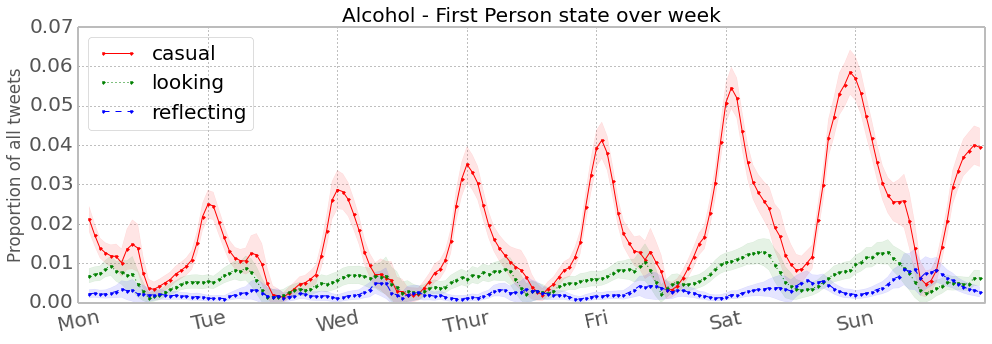

In [82]:
temp = df.groupby([df.index.dayofweek, df.index.hour]).agg(
    {
        _:{"mean":"mean", "err":centered_95int} for _ in new_fp_cols
    }
)

stds = pd.rolling_mean(temp[[1,3,5]], 3)
means = pd.rolling_mean(temp[[0,2,4]], 3)

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]


fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(means.casual, "r.-", label="casual")
ax.fill_between(
    x=range(24*7),
    y1=means.casual - stds.casual,
    y2=means.casual + stds.casual,
    color='r', alpha=.1
)


ax.plot(means.looking, "g.:", label="looking")
ax.fill_between(
    x=range(24*7),
    y1=means.looking - stds.looking,
    y2=means.looking + stds.looking,
    color="g", alpha=.1
)



ax.plot(means.reflecting, "b.--", label="reflecting")
ax.fill_between(
    x=range(24*7),
    y1=means.reflecting - stds.reflecting,
    y2=means.reflecting + stds.reflecting,
    color="b", alpha=.1
)


ax.set_xlim([0, 24*7])
ax.set_ylim([0, .07])
ax.set_xticks(range(0, 24*7, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"], rotation=12)
ax.set_title("Alcohol - First Person state over week")
ax.set_ylabel("Proportion of all tweets")
ax.legend(loc="best")
plt.savefig("../../Desktop/plt_levels_weekhour.pdf")

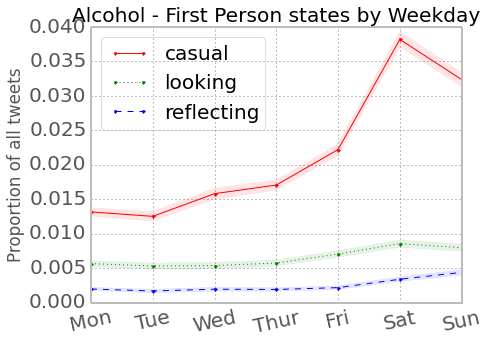

In [83]:
temp = df.groupby([df.index.dayofweek]).agg(
    {
        _:{"mean":"mean", "err":centered_95int} for _ in new_fp_cols
    }
)

stds = pd.rolling_mean(temp[[1,3,5]], 1)
means = temp[[0,2,4]]

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]


fig = plt.figure(figsize=(7,5))

ax = fig.add_subplot(111)
ax.plot(means.casual, "r.-", label="casual")
ax.fill_between(
    x=range(7),
    y1=means.casual - stds.casual,
    y2=means.casual + stds.casual,
    color="r", alpha=.1
)

ax.plot(means.looking, "g.:", label="looking")
ax.fill_between(
    x=range(7),
    y1=means.looking - stds.looking,
    y2=means.looking + stds.looking,
    color="g", alpha=.1
)



ax.plot(means.reflecting, "b.--", label="reflecting")
ax.fill_between(
    x=range(7),
    y1=means.reflecting - stds.reflecting,
    y2=means.reflecting + stds.reflecting,
    color="b", alpha=.1
)


ax.set_xticks(range(0, 7))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"], rotation=12)
ax.set_title("Alcohol - First Person states by Weekday")
ax.set_ylabel("Proportion of all tweets")
ax.legend(loc="best")
plt.savefig("../../Desktop/plt_levels_week.pdf")

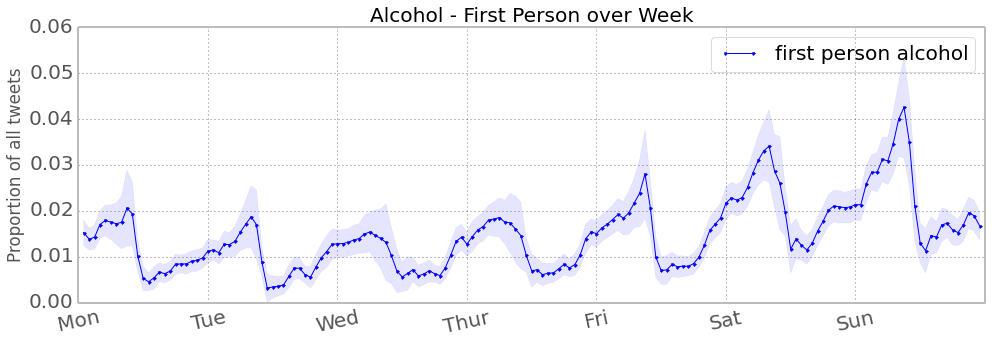

In [84]:
temp = df.groupby([df.index.dayofweek, df.index.hour]).agg(
    {
        'first_person_alcohol' : {"mean":"mean", "err":centered_95int}
    }
)

means = pd.rolling_mean(temp[[0]], 2)
stds = temp[[1]] 

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]


fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(means.first_person_alcohol, "b.-", label="first person alcohol")
ax.fill_between(
    x=range(24*7),
    y1=means.first_person_alcohol - stds.first_person_alcohol,
    y2=means.first_person_alcohol + stds.first_person_alcohol,
    color="b", alpha=.1
)


ax.set_xlim([0, 24*7])
ax.set_xticks(range(0, 24*7, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"], rotation=12)
ax.set_ylabel("Proportion of all tweets")
ax.set_title("Alcohol - First Person over Week")
ax.legend(loc="best")
plt.savefig("../../Desktop/plt_fp_weekhour.pdf")

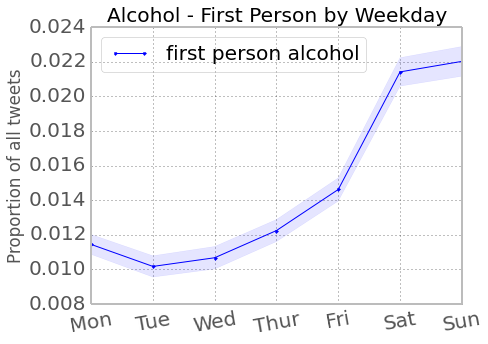

In [85]:
fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111)

temp = df.groupby([df.index.dayofweek]).agg(
    {
        'first_person_alcohol' : {"mean":"mean", "err":centered_95int}
    }
)

stds = temp[[1]]
means = temp[[0]] 

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]
ax.plot(means.first_person_alcohol, "b.-", label="first person alcohol")
ax.fill_between(
    x=range(7),
    y1=means.first_person_alcohol - stds.first_person_alcohol,
    y2=means.first_person_alcohol + stds.first_person_alcohol,
    color="b", alpha=.1
)

ax.set_xticks(range(0, 7))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"], rotation=10)

ax.set_ylabel("Proportion of all tweets")
ax.set_title("Alcohol - First Person by Weekday")
ax.legend(loc="best")



plt.savefig("../../Desktop/plt_fp_week.pdf")

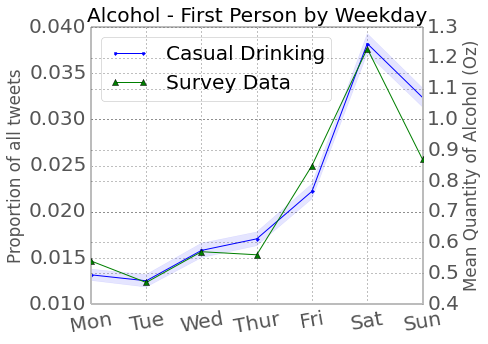

In [86]:
fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111)

cls = 'casual'

temp = df.groupby([df.index.dayofweek]).agg(
    {
        cls : {"mean":"mean", "err":centered_95int}
    }
)

stds = temp[[1]]
means = temp[[0]] 

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]

l1 = ax.plot(means[cls], "b.-", label="Casual Drinking")
ax.fill_between(
    x=range(7),
    y1=means[cls] - stds[cls],
    y2=means[cls] + stds[cls],
    color="b", alpha=.1
)

ax2 = ax.twinx()
l2 = ax2.plot([0.54,0.47,0.57,0.56,0.85,1.23,0.87], 'g^-', label="Survey Data")
ax2.set_ylabel("Mean Quantity of Alcohol (Oz)")
ax.set_xticks(range(0, 7))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"], rotation=10)

ax.set_ylabel("Proportion of all tweets")
ax.set_title("Alcohol - First Person by Weekday")

labs = [l.get_label() for l in l1+l2]
ax.legend(l1+l2, labs, loc=0)



plt.savefig("../../Desktop/plt_fp_vs_survey.pdf")

# Weekday vs Weekend

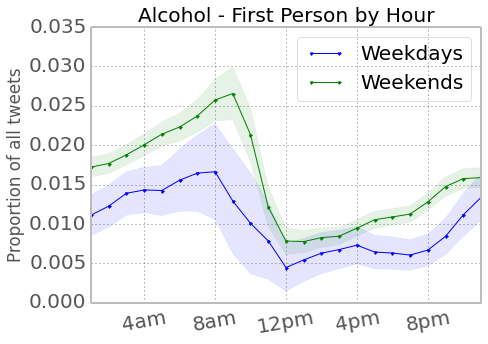

In [87]:
fig = plt.figure(figsize=(7, 5))


weekday = df.index.day < 5

ax = fig.add_subplot(111)

temp = df[weekday].groupby([df[weekday].index.hour]).agg(
    {
        'first_person_alcohol' : {"mean":"mean", "err":centered_95int}
    }
)

stds = pd.rolling_mean(temp[[1]], 2)
means = pd.rolling_mean(temp[[0]], 2)

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]
ax.plot(means.first_person_alcohol, "b.-", label="Weekdays")
ax.fill_between(
    x=range(24),
    y1=means.first_person_alcohol - stds.first_person_alcohol,
    y2=means.first_person_alcohol + stds.first_person_alcohol,
    color="b", alpha=.1
)


temp = df[~weekday].groupby([df[~weekday].index.hour]).agg(
    {
        'first_person_alcohol' : {"mean":"mean", "err":centered_95int}
    }
)

stds = pd.rolling_mean(temp[[1]], 2)
means = pd.rolling_mean(temp[[0]], 2)

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]
ax.plot(means.first_person_alcohol, "g.-", label="Weekends")
ax.fill_between(
    x=range(24),
    y1=means.first_person_alcohol - stds.first_person_alcohol,
    y2=means.first_person_alcohol + stds.first_person_alcohol,
    color="g", alpha=.1
)

ax.set_xticks([0, 4, 8, 12, 12+4, 12+8])
ax.set_xticklabels(["12am", "4am", "8am", "12pm", "4pm", "8pm"], rotation=10)
ax.set_xlim([1, 23])
ax.set_ylim([0, .035])
ax.set_ylabel("Proportion of all tweets")
ax.set_title("Alcohol - First Person by Hour")
ax.legend(loc="upper right")
ax.legend(loc="best")

plt.savefig("../../Desktop/plt_fp_hour.pdf")

# New Years

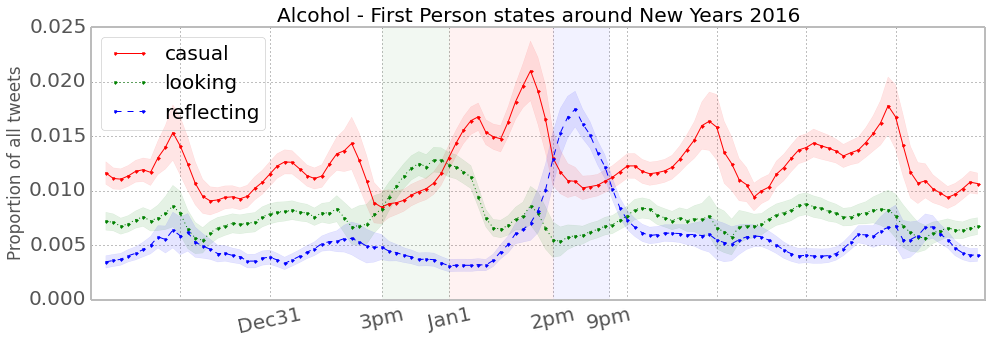

In [88]:
temp = df3.groupby([df3.index.year, df3.index.day, df3.index.hour]).agg(
    {
        _:{"mean":"mean", "err":centered_95int} for _ in new_fp_cols
    }
)

stds = pd.rolling_mean(temp[[1,3,5]], 3)
means = pd.rolling_mean(temp[[0,2,4]], 3)

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]

fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(111)
ax.plot(means.casual, "r.-", label="casual")
ax.fill_between(
    x=range(5*24),
    y1=means.casual - stds.casual,
    y2=means.casual + stds.casual,
    color="r", alpha=.1
)


ax.plot(means.looking, "g.:", label="looking")
ax.fill_between(
    x=range(5*24),
    y1=means.looking - stds.looking,
    y2=means.looking + stds.looking,
    color="g", alpha=.1
)

ax.plot(means.reflecting, "b.--", label="reflecting")
ax.fill_between(
    x=range(5*24),
    y1=means.reflecting - stds.reflecting,
    y2=means.reflecting + stds.reflecting,
    color="b", alpha=.1
)

ax.set_title("Alcohol - First Person states around New Years 2016")
ax.set_xticks([0, 12, 24, 36+3, 48, 60+2, 60+2+7.5, 72, 84, 96, 108, 120])

ax.set_xticklabels([
        "", "", "Dec31", "3pm", "Jan1", "2pm", "9pm", ""
    ], rotation=12)

ax.add_patch(m.patches.Rectangle((48, 0), 14, 12, color='red', alpha=0.05))

ax.add_patch(m.patches.Rectangle((39, 0), 9, 12, color='green', alpha=0.05))
ax.add_patch(m.patches.Rectangle((62, 0), 7.5, 12, color='blue', alpha=0.05))
ax.set_ylabel("Proportion of all tweets")
ax.legend(loc="best")
plt.savefig("../../Desktop/plt_levels_new_years.pdf")

# Gender

In [89]:
id2gender = pd.DataFrame.from_csv("./id2gender.csv")

gender_map = {
    "Other": "Other",
    "male": "Male",
    "female": "Female",
    "mostly_female": "Female",
    "mostly_male": "Male"
}

id2gender = id2gender.reset_index()
id2gender.index = id2gender.user_id.apply(try_or(lambda _: int(_), lambda _: None))

id2gender.gender = id2gender.gender.apply(gender_map.get)
id2gender = id2gender.gender.to_dict()
df["user_gender"] = df.user_id.apply(id2gender.get)

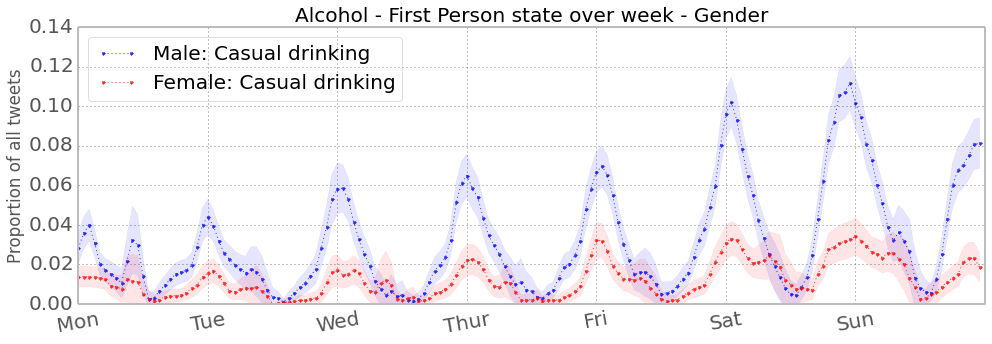

In [90]:
temp = df.groupby([df.user_gender, df.index.dayofweek, df.index.hour]).agg(
    {
        _:{"mean":"mean", "err":centered_95int} for _ in new_fp_cols
    }
)

stds = pd.rolling_mean(temp[[1,3,5]], 3).fillna(method="bfill")
means = pd.rolling_mean(temp[[0,2,4]], 3).fillna(method="bfill")

means.columns = [col[0] for col in means.columns.values]
stds.columns = [col[0] for col in stds.columns.values]


fig = plt.figure(figsize=(14,5))


def plot(ax, gender, means, stds):
    
    gender2style = {
        "Female": "r.:",
        "Male": "b.:"
    }
    
    means = means.loc[gender]
    stds = stds.loc[gender]

    ax.plot(means.casual, gender2style[gender], label=gender + ": Casual drinking", alpha=.8)
    ax.fill_between(
        x=range(24*7),
        y1=means.casual - stds.casual,
        y2=means.casual + stds.casual,
        color=gender2style[gender][0], alpha=.1
    )
"""
    ax.plot(means.looking, "g.:", label="looking")
    ax.fill_between(
        x=range(24*7),
        y1=means.looking - stds.looking,
        y2=means.looking + stds.looking,
        color="g", alpha=.1
    )



    ax.plot(means.reflecting, "b.--", label="reflecting")
    ax.fill_between(
        x=range(24*7),
        y1=means.reflecting - stds.reflecting,
        y2=means.reflecting + stds.reflecting,
        color="b", alpha=.1
    )
"""

    
ax = fig.add_subplot(111)
plot(ax, "Male", means, stds)

ax.set_xlim([0, 24*7])
ax.set_ylim([0, .14])
ax.set_xticks(range(0, 24*7, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"], rotation=10)
ax.set_title("Alcohol - First Person state over week - Gender")
ax.set_ylabel("Proportion of all tweets")

plot(ax, "Female", means, stds)

ax.legend(loc="best")
plt.savefig("../../Desktop/plt_levels_week_gender.pdf")

In [91]:
plt.savefig?